In [1]:
from bw2data import projects, methods, Database, databases
from bw2io import create_default_lcia_methods
from bw2calc import LCA

## Select project, demand, method

In [2]:
projects.set_current("EXIOBASE regionalized case study")

In [3]:
# Add methods if there are none
if ('IPCC 2013', 'climate change', 'GWP 100a') not in methods:
    create_default_lcia_methods(overwrite=True)

Applying strategy: normalize_units
Applying strategy: set_biosphere_type
Applying strategy: fix_ecoinvent_38_lcia_implementation
Applying strategy: drop_unspecified_subcategories
Applying strategy: link_iterable_by_fields
Applied 5 strategies in 0.61 seconds
Wrote 975 LCIA methods with 254388 characterization factors


In [4]:
# Copy existing `Oil seeds` database and name it `Independent oil`
if "Independent oil" in databases: # if already exists, delete first
    del databases['Independent oil']
Database("Oil seeds").copy("Independent oil")

Not able to determine geocollections for all datasets. This database is not ready for regionalization.
Title: Writing activities to SQLite3 database:
  Started: 04/27/2022 09:40:48
  Finished: 04/27/2022 09:40:48
  Total time elapsed: 00:00:00
  CPU %: 104.90
  Memory %: 1.28


Brightway2 SQLiteBackend: Independent oil

In [5]:
databases

Databases dictionary with 5 object(s):
	EXIOBASE 3.3.18 hybrid
	EXIOBASE 3.3.18 hybrid biosphere
	Independent oil
	Oil seeds
	biosphere3

In [6]:
# Select LCIA method
gwp = ('IPCC 2013', 'climate change', 'GWP 100a')

In [7]:
# Get access to the database `Independent oil`
db = Database("Independent oil")

In [8]:
len(db)

257

In [9]:
# Select random activity that has exchanges to see attributes of the exchanges
activity_with_exc_found = False
while not activity_with_exc_found:
    act = db.random()
    try: 
        exc = list(act.technosphere())[0]
        activity_with_exc_found = True
    except:
        pass

In [10]:
exc

Exchange: 1.0 tonnes 'Mining of chemical and fertilizer minerals, production of salt, other mining and quarrying n.e.c.' (tonnes, WE, None) to 'Bleaching earth' (tonnes, UA, None)>

In [11]:
act.as_dict()

{'code': 'Link to: Bleaching earth {UA}',
 'name': 'Bleaching earth',
 'location': 'UA',
 'unit': 'tonnes',
 'category': '\\_5 Veg Oil case\\_Link to background: Exiobase',
 'comment': 'Link to Exiobase v3.3.13b2. This activity is empty because the refinery capital goods and services are already included with the oil mill capital goods and services (because the oil mill and refinery are aggregated in Exiobase)',
 'kind': 'Material',
 'database': 'Independent oil',
 'reference product': 'Link to: Bleaching earth',
 'production amount': 1,
 'id': 11462}

In [12]:
# Note that both input and output of an exchange are Activities (nodes of graph)
type(exc.input), type(exc.output), type(exc)

(bw2data.backends.proxies.Activity,
 bw2data.backends.proxies.Activity,
 bw2data.backends.proxies.Exchange)

In [13]:
# Check out all information in the exchange
exc.as_dict()

{'code': '_34 Mining of chemical and fertilizer minerals, production of salt, other mining and quarrying n.e.c. {WE} (product market, hybrid units)',
 'amount': 1.0,
 'type': 'technosphere',
 'unit': 'tonnes',
 'name': 'Mining of chemical and fertilizer minerals, production of salt, other mining and quarrying n.e.c.',
 'location': 'WE',
 'input': ('EXIOBASE 3.3.18 hybrid',
  'WE|Mining of chemical and fertilizer minerals, production of salt, other mining and quarrying n.e.c.'),
 'output': ('Independent oil', 'Link to: Bleaching earth {UA}')}

## Delete all exchanges that are linked to exiobase

In [14]:
# Total number of exchanges in db BEFORE separating db from exiobase
sum([len(list(ds.exchanges())) for ds in db])

912

In [15]:
for ds in db:
    for exc in ds.technosphere():
        if exc.input['database'] == 'EXIOBASE 3.3.18 hybrid':
            exc.delete()

In [16]:
# AFTER
sum([len(list(ds.exchanges())) for ds in db])

471

## Find activity with non-zero impact score

In [17]:
lca = LCA({db.random(): 1}, gwp)
lca.lci()
lca.lcia()
lca.score

0.0

In [18]:
lca.demand

{11663: 1}

In [19]:
# Created technosphere matrix has only 257 activities
lca.technosphere_matrix

<257x257 sparse matrix of type '<class 'numpy.float64'>'
	with 426 stored elements in Compressed Sparse Row format>

Question: why are there fewer stored elements than number of exchanges?

In [20]:
# Find activity in `db` with non-zero impact score to run MC simulations with non-zero outputs
for act in db:
    if lca.score == 0:
        lca.redo_lcia({act.id: 1})
    else:
        break
lca.score

2.1232650513315416

In [21]:
# Corresponding demand
lca.demand

{11701: 1}

## Add uncertainty information to all exchanges. 

Uncertainty type 5 corresponds to triangular distribution.

Check out more in the stats_array library [here](https://stats-arrays.readthedocs.io/en/latest/).

In [22]:
for ds in Database("Independent oil"):
    for exc in ds.technosphere():
        if exc['amount'] < 0:
            exc['uncertainty type'] = 5 
            exc['maximum'] = 0.75 * exc['amount']
            exc['minimum'] = 1.5 * exc['amount']
            exc['loc'] = exc['amount']
            exc.save()
        if exc['amount'] > 0:
            exc['uncertainty type'] = 5
            exc['minimum'] = 0.75 * exc['amount']
            exc['maximum'] = 1.5 * exc['amount']
            exc['loc'] = exc['amount']
            exc.save()            

## Do Monte Carlo LCA

In [23]:
lca = LCA({act: 1}, gwp, use_distributions=True)
lca.lci()
lca.lcia()
lca.score

1.4772607950951604

In [31]:
for _ in range(5):
    next(lca)
    print(lca.score)

0.4941139165145958
0.5869260920057139
1.380619687563578
0.1514826877012346
0.7307141810211533


In [32]:
%%time
n_runs = 2700
_, values = zip(*[(next(lca), lca.score) for _ in range(n_runs)])

CPU times: user 1min 5s, sys: 1.57 s, total: 1min 6s
Wall time: 16.7 s


In [33]:
values[:5]

(0.47840136784146836,
 0.4630247837514764,
 0.8095741315860581,
 0.7454620291991803,
 0.47688376335235017)

## Let us plot a histogram of these values

In [34]:
import matplotlib.pyplot as plt

In [35]:
%matplotlib inline

(array([  9.,  65., 155., 322., 456., 430., 392., 302., 220., 119.,  95.,
         60.,  28.,  23.,  13.,   2.,   2.,   1.,   4.,   2.]),
 array([-1.66219740e-01, -5.96149281e-04,  1.65027441e-01,  3.30651031e-01,
         4.96274622e-01,  6.61898212e-01,  8.27521802e-01,  9.93145393e-01,
         1.15876898e+00,  1.32439257e+00,  1.49001616e+00,  1.65563975e+00,
         1.82126334e+00,  1.98688693e+00,  2.15251052e+00,  2.31813412e+00,
         2.48375771e+00,  2.64938130e+00,  2.81500489e+00,  2.98062848e+00,
         3.14625207e+00]),
 <BarContainer object of 20 artists>)

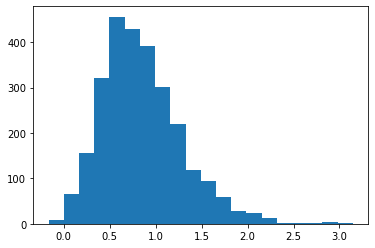

In [36]:
plt.hist(values, bins=20)